INFO | Registros totais: 18898 | % verdadeiras: 49.8


Fitting 5 folds for each of 12 candidates, totalling 60 fits


INFO | Melhores parâmetros: {'knn__n_neighbors': 5, 'tfidf__max_features': 10000} | F1 = 0.933


Acurácia.............: 0.9305
Precisão............: 0.8963
Recall..............: 0.9731
Especificidade......: 0.8882
F1‑Score............: 0.9332
AUC.................: 0.9649


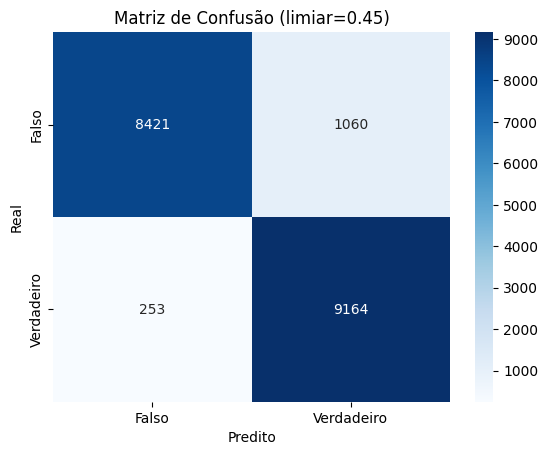

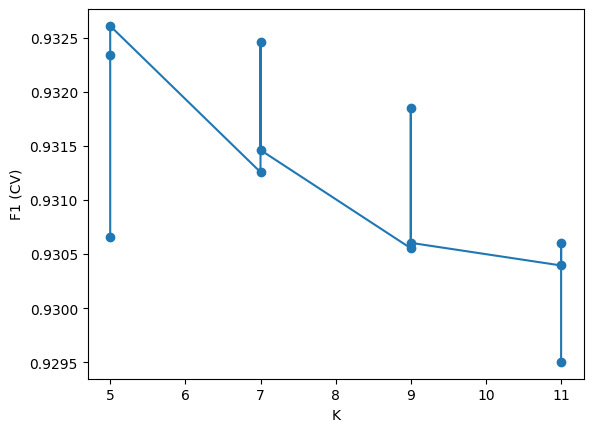

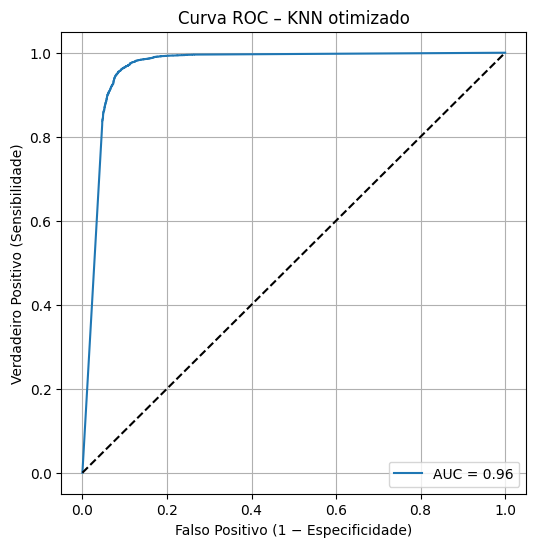

['modelo_knn_tfidf_otimizado.joblib']

In [ ]:

"""
Notebook único — Classificador de Notícias  
Pipeline **TF‑IDF → (LSA opcional) → K‑NN** com ajuste de limiar.

A célula está dividida em quatro blocos indicados nos comentários:

* Questão 1 – Preparação dos dados  
* Questão 2 – Pipeline + GridSearchCV  
* Questão 3 – Validação cruzada + ajuste de limiar  
* Questão 4 – Métricas, matriz de confusão e curva ROC
"""
# -----------------------------------------------------------------------------#
# IMPORTAÇÕES e CONFIGURAÇÕES
# -----------------------------------------------------------------------------#
import logging
from pathlib import Path
import numpy as np
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
RANDOM_STATE = 42
DATA_DIR = Path("data")
ARQ_FAKE = DATA_DIR / "Fake.csv"
ARQ_TRUE = DATA_DIR / "True.csv"

# -----------------------------------------------------------------------------#
# QUESTÃO 1 – CARREGAMENTO E TF‑IDF
# -----------------------------------------------------------------------------#
colunas = ["titulo", "texto", "categoria", "data"]
df_fake = pd.read_csv(ARQ_FAKE, header=None, names=colunas, quotechar='"', skipinitialspace=True)
df_true = pd.read_csv(ARQ_TRUE, header=None, names=colunas, quotechar='"', skipinitialspace=True)
df_fake["target"], df_true["target"] = 0, 1
df = pd.concat([df_fake, df_true], ignore_index=True)
df["texto"] = df["texto"].fillna("")

logging.info("Registros totais: %d | %% verdadeiras: %.1f",
             len(df), 100 * df["target"].mean())

X, y = df["texto"], df["target"]

# -----------------------------------------------------------------------------#
# QUESTÃO 2 – PIPELINE + GRIDSEARCHCV
# -----------------------------------------------------------------------------#
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 3),
        min_df=3,
        sublinear_tf=True,
        smooth_idf=True,
        analyzer="word",
    )),
    # Opcional: comente para pular LSA
    ("svd", TruncatedSVD(n_components=300, random_state=RANDOM_STATE)),
    ("knn", KNeighborsClassifier(
        algorithm="brute",
        metric="cosine",
        weights="distance",
        n_jobs=-1,
    )),
])

param_grid = {
    "knn__n_neighbors": [5, 7, 9, 11],
    "tfidf__max_features": [2000, 5000, 10000],
}

cv_grid = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
search = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1",
    cv=cv_grid,
    n_jobs=-1,
    verbose=1,
)
search.fit(X, y)
best_model = search.best_estimator_
logging.info("Melhores parâmetros: %s | F1 = %.3f",
             search.best_params_, search.best_score_)

# -----------------------------------------------------------------------------#
# QUESTÃO 3 – VALIDAÇÃO CRUZADA + AJUSTE DE LIMIAR
# -----------------------------------------------------------------------------#
cv_eval = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
y_prob = cross_val_predict(best_model, X, y, cv=cv_eval, method="predict_proba")[:, 1]

limiar = 0.45  # ajuste fino: aumenta recall aceitando leve queda de precisão
y_pred = (y_prob >= limiar).astype(int)

# -----------------------------------------------------------------------------#
# QUESTÃO 4 – MÉTRICAS, MATRIZ DE CONFUSÃO, CURVA ROC, PRECISÃO, RECALL, F1-SCORE, SENSIBILIDADE, ESPECIFICIDADE
# -----------------------------------------------------------------------------#
acc  = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec  = recall_score(y, y_pred)
f1   = f1_score(y, y_pred)
cm   = confusion_matrix(y, y_pred)
esp  = cm[0, 0] / (cm[0, 0] + cm[0, 1])
fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

print(f"Acurácia.............: {acc:.4f}")
print(f"Precisão............: {prec:.4f}")
print(f"Recall..............: {rec:.4f}")
print(f"Especificidade......: {esp:.4f}")
print(f"F1‑Score............: {f1:.4f}")
print(f"AUC.................: {roc_auc:.4f}")

# Matriz de confusão
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Falso", "Verdadeiro"],
    yticklabels=["Falso", "Verdadeiro"],
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title(f"Matriz de Confusão (limiar={limiar})")
plt.show()

k_vals  = search.cv_results_['param_knn__n_neighbors'].data.astype(int)
scores  = search.cv_results_['mean_test_score']
plt.plot(k_vals, scores, marker='o'); plt.xlabel('K'); plt.ylabel('F1 (CV)')

# Curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Falso Positivo (1 − Especificidade)")
plt.ylabel("Verdadeiro Positivo (Sensibilidade)")
plt.title("Curva ROC – KNN otimizado")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Persistência
joblib.dump(best_model, "modelo_knn_tfidf_otimizado.joblib")
